# Final Project Model Deployment

by 2702221135 - Octavius Sandriago

https://binusianorg-my.sharepoint.com/personal/octavius_sandriago_binus_ac_id/_layouts/15/guestaccess.aspx?share=EQ6cvKITRxRIg6KfXLO4K4cBEyBx3fV3LgLAtgqeQtnzDw&e=eemCWg

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import xgboost as xgb
import pickle

In [4]:
df = pd.read_csv('../../Dataset/ObesityDataSet1.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,31,1.87,128.87,yes,yes,2.96,3.00,Sometimes,yes,1.28,no,0.90,1.875,Sometimes,Automobile,Obesity_Type_II
1,Female,18,1.59,40.00,yes,yes,2.00,1.00,Frequently,no,1.00,no,0.00,2.000,no,Public_Transportation,Insufficient_Weight
2,Female,44 years,1.59,77.00,yes,yes,2.00,3.00,Sometimes,no,2.81,no,0.00,0.000,Sometimes,Automobile,Obesity_Type_I
3,Male,31,1.68,102.00,yes,yes,2.94,2.14,Sometimes,no,1.25,no,1.18,0.778,no,Public_Transportation,Obesity_Type_II
4,Male,22,1.74,75.00,yes,yes,3.00,3.00,Frequently,no,1.00,no,1.00,0.000,no,Automobile,Normal_Weight


### Finding Anomalies

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1055 non-null   object 
 1   Age                             1055 non-null   object 
 2   Height                          1055 non-null   float64
 3   Weight                          1055 non-null   float64
 4   family_history_with_overweight  1055 non-null   object 
 5   FAVC                            1055 non-null   object 
 6   FCVC                            1055 non-null   float64
 7   NCP                             1055 non-null   float64
 8   CAEC                            1029 non-null   object 
 9   SMOKE                           1055 non-null   object 
 10  CH2O                            1055 non-null   float64
 11  SCC                             1055 non-null   object 
 12  FAF                             10

__EXPLANATION__ : 

There is wrong format for:
- age is object, should be float

In [6]:
non_numeric_ages = df[pd.to_numeric(df['Age'], errors='coerce').isna()]['Age']
print(non_numeric_ages.unique())

['44 years' '19 years' '21 years' '22 years' '18 years' '23 years'
 '26 years' '20 years' '32 years' '33 years']


__EXPLANATION__ : We need to change these to numeric values

In [7]:
df.isna().sum()

Gender                             0
Age                                0
Height                             0
Weight                             0
family_history_with_overweight     0
FAVC                               0
FCVC                               0
NCP                                0
CAEC                              26
SMOKE                              0
CH2O                               0
SCC                                0
FAF                                0
TUE                               37
CALC                               0
MTRANS                             0
NObeyesdad                         0
dtype: int64

In [8]:
print(df['CAEC'].isna().sum() / len(df) * 100)
print(df['TUE'].isna().sum() / len(df) * 100)

2.4644549763033177
3.5071090047393367


__EXPLANATION__ : 
- CAEC column has 26 missing values or 2.46% of its value is missing, because it is quite small percentage of data (<10%) we can impute it
- TUE column has 37 missing values or 3.5% of its value is missing, because it is quite small percentage of data (<10%) we can impute it

### Handling Anomalies

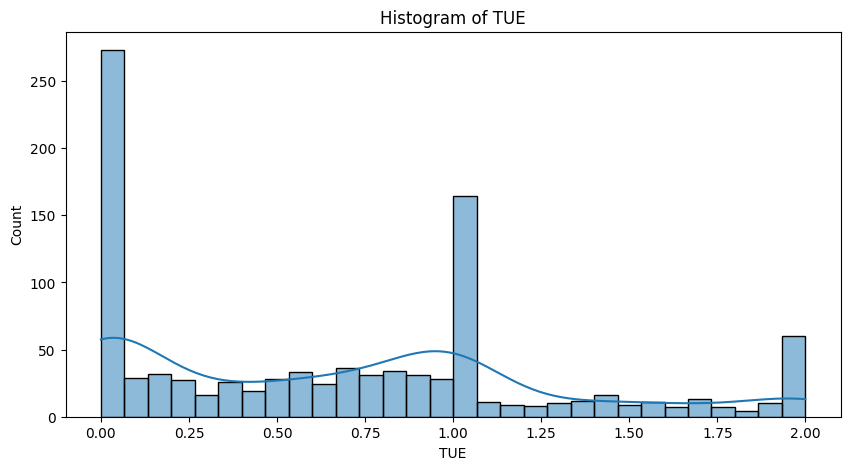

In [9]:
# Plot the distribution of 'TUE'
plt.figure(figsize=(10,5))
sns.histplot(df['TUE'], bins=30, kde=True)
plt.title(f'Histogram of TUE')

plt.show()

__EXPLANATION__ : Plot the distribution of TUE, and can be seen it is not normally distributed,  meaning we impute it with its median

In [10]:
# Fill missing values 
df['TUE'] = df['TUE'].fillna(df['TUE'].median())
df['CAEC'] = df['CAEC'].fillna(df['CAEC'].mode()[0])
df.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [11]:
# Remove " years" from the Age values and convert to numeric
df['Age'] = df['Age'].str.replace(' years', '', regex=False)
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

In [12]:
print(df['Age'].describe())

count    1055.000000
mean       24.396209
std         6.394850
min        16.000000
25%        20.000000
50%        23.000000
75%        26.000000
max        61.000000
Name: Age, dtype: float64


### EDA

In [13]:
categorical = []
numerical = []

for i in df.columns:
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        numerical.append(i)
    else:
        categorical.append(i)

print(f'Categorical: {categorical}')
print(f'Numeric: {numerical}')

Categorical: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']
Numeric: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


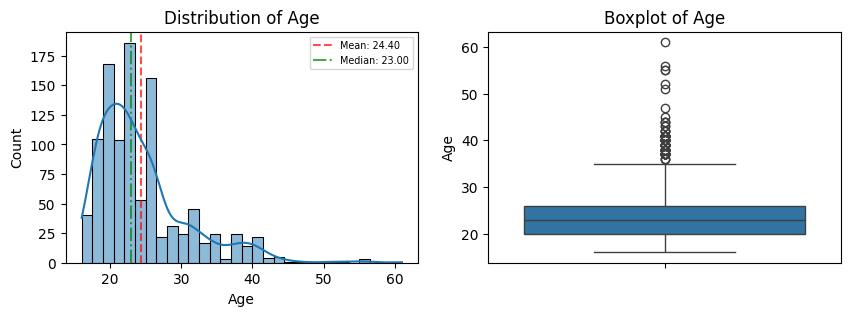

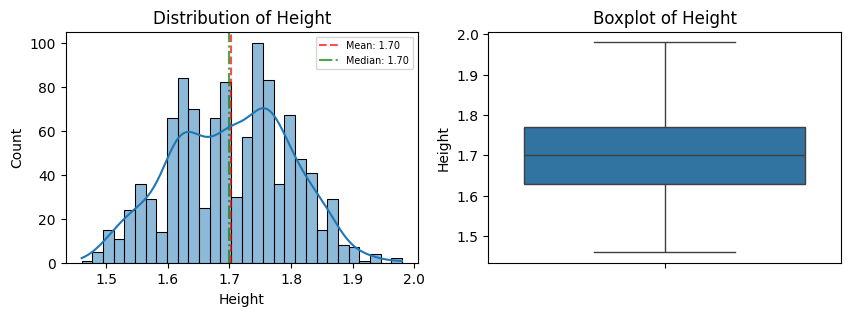

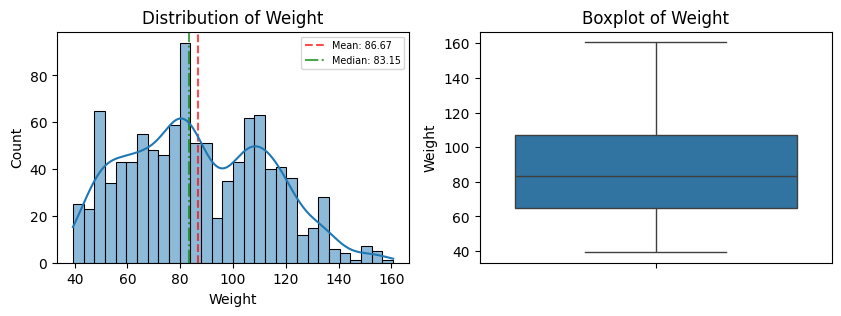

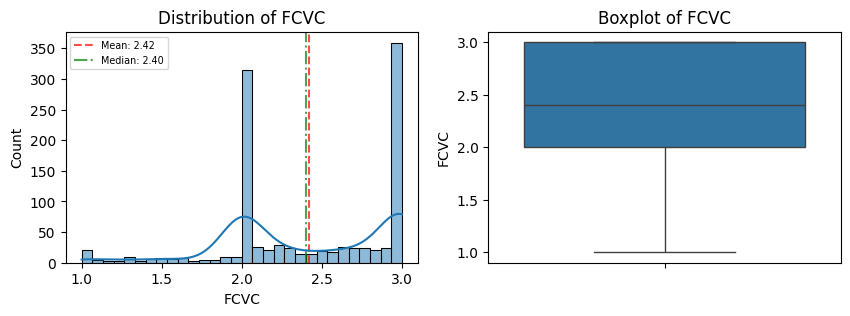

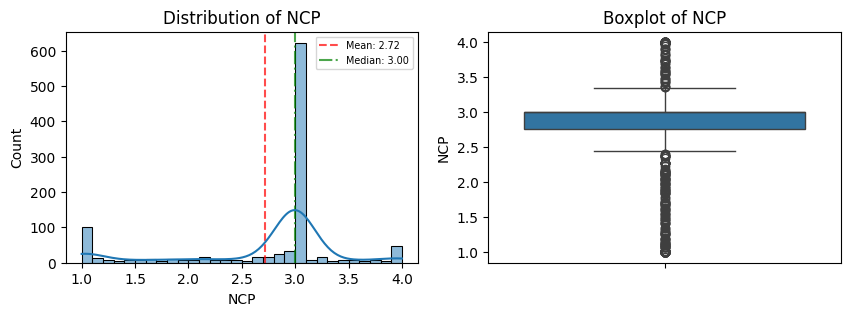

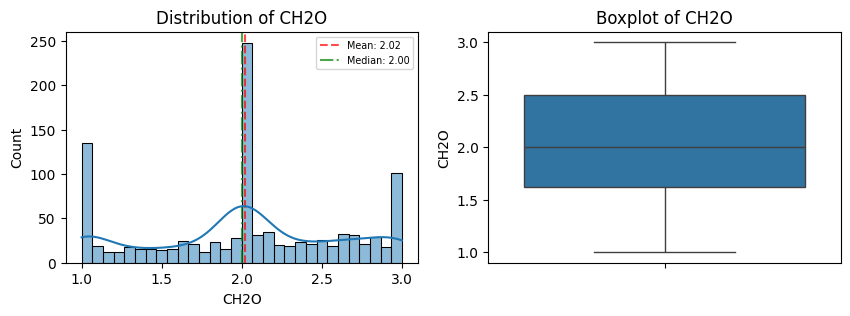

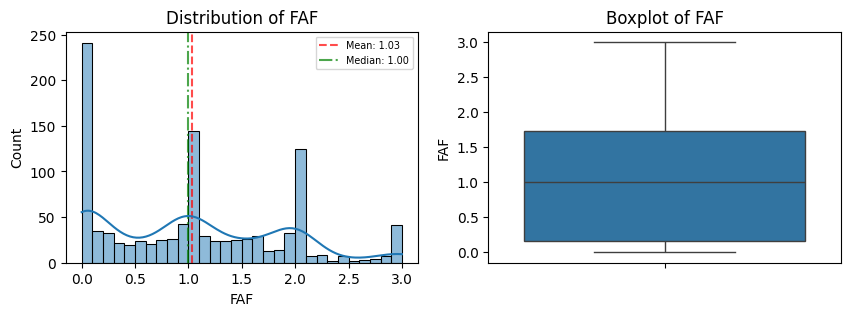

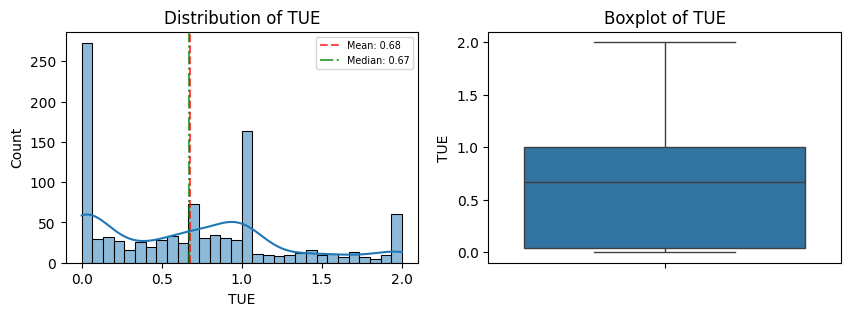

In [14]:
# Plotting the numerical columns
for col in numerical:
        plt.figure(figsize=(10, 3))

        # Plot Histogram
        mean = df[col].mean()
        median = df[col].median()
        skew = df[col].skew()
        kurt = df[col].kurt()
        plt.subplot(1, 2, 1)
        plt.axvline(mean, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean:.2f}')
        plt.axvline(median, color='green', linestyle='-.', alpha=0.7, label=f'Median: {median:.2f}')
        plt.legend(fontsize='x-small')
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f'Distribution of {col}')

        # Plot Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')

        plt.show()

__EXPLANATION__ : All of the numerical columns are not normally distributed and there are a lot outliers

In [15]:
# Convert categorical columns to lowercase and strip whitespace
for col in categorical:
    df[col] = df[col].astype(str).str.lower().str.strip()

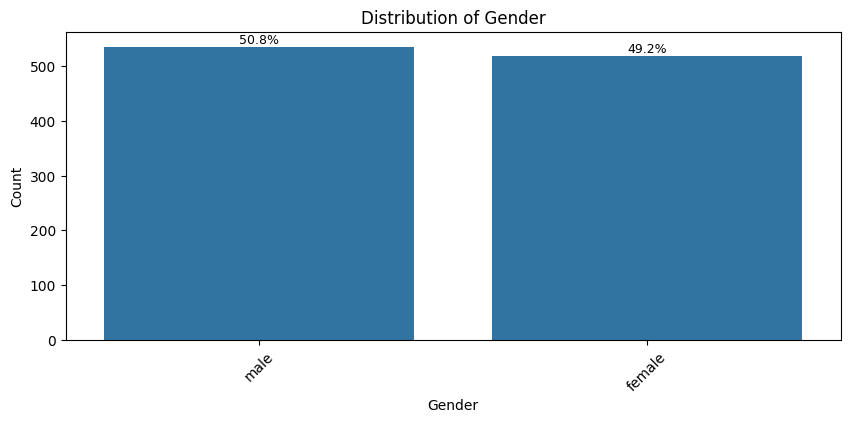

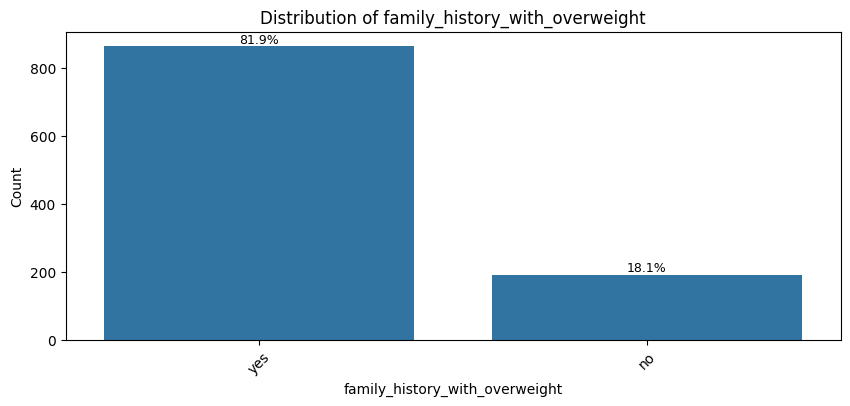

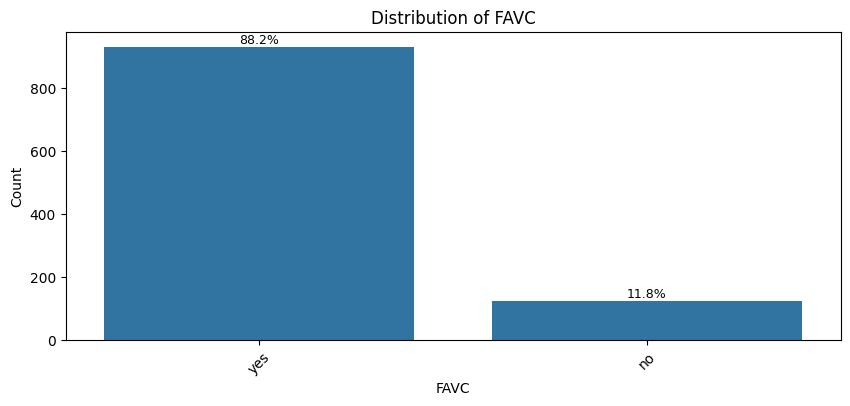

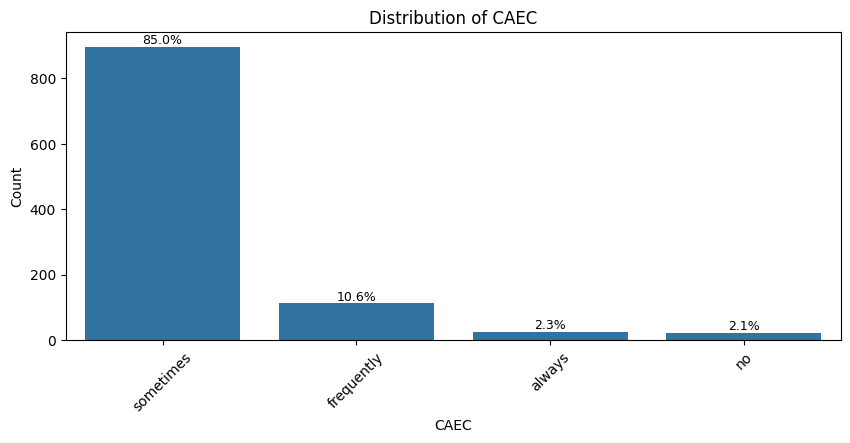

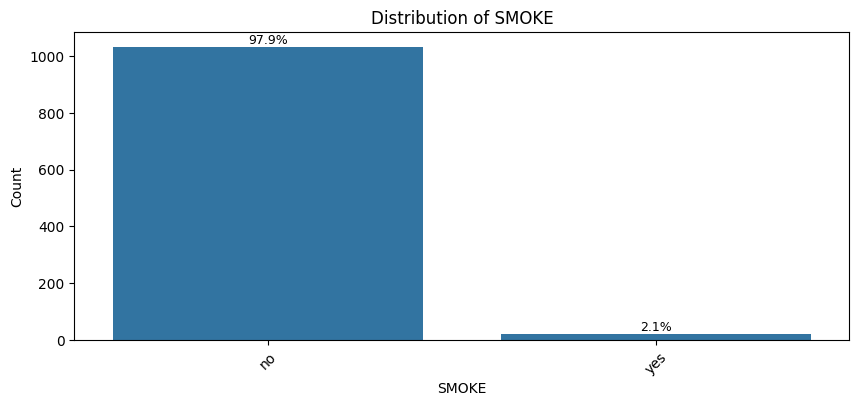

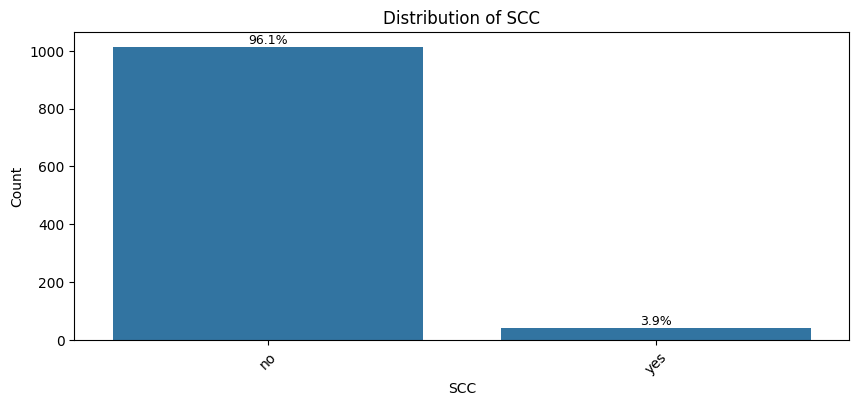

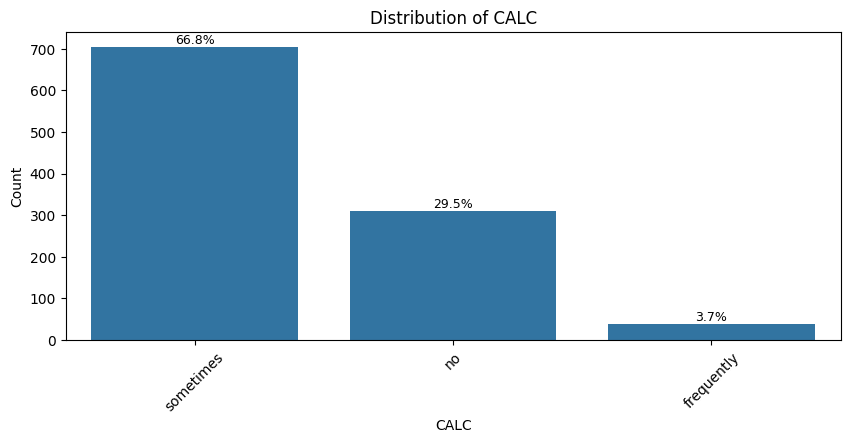

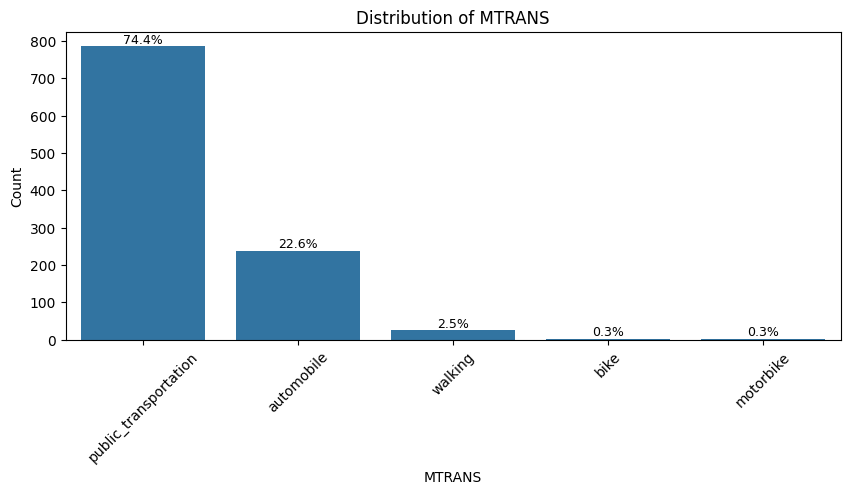

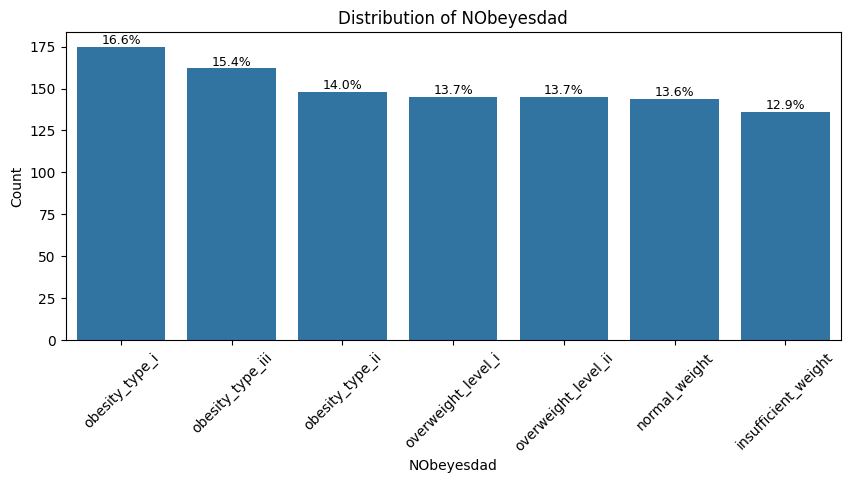

In [16]:
# Plotting the categorical columns
for cat_col in categorical:
    plt.figure(figsize=(10, 4))
    
    ax = sns.countplot(x=cat_col, data=df, order=df[cat_col].value_counts().index)
    
    total = len(df[cat_col])
    for p in ax.patches:
        height = p.get_height()
        percentage = f'{100 * height / total:.1f}%'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)
    
    plt.title(f'Distribution of {cat_col}')
    plt.xticks(rotation=45)
    plt.xlabel(cat_col)
    plt.ylabel("Count")
    
    plt.show()


__EXPLANATION__ : From here, we can see that there are no wrong format for the categorical columns

### Splitting Data

In [17]:
target_col = 'NObeyesdad'

In [18]:
x = df[df.columns.drop(target_col)]
y = df[target_col]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

### Pre Processing

In [19]:
min_max_scaler = MinMaxScaler()

x_train[numerical] = min_max_scaler.fit_transform(x_train[numerical])
x_test[numerical] = min_max_scaler.transform(x_test[numerical])

__EXPLANATION__ : We only scale the numerical values

In [20]:
categorical

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS',
 'NObeyesdad']

In [21]:
# Seperate hierarchical and non-hierarchical categorical variables
hierarchical_cols = ['CAEC', 'CALC', target_col]

non_hierarchical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']

hierarchical_cols = [col for col in hierarchical_cols if col in categorical]
non_hierarchical_cols = [col for col in non_hierarchical_cols if col in categorical]

In [22]:
# encode the non-hierarchal categorical with using OneHotEncoder
oh_encoder = OneHotEncoder(sparse_output=False)

x_train_oh = oh_encoder.fit_transform(x_train[non_hierarchical_cols])
x_test_oh = oh_encoder.transform(x_test[non_hierarchical_cols])

oh_columns = oh_encoder.get_feature_names_out(non_hierarchical_cols)

# Convert to DataFrame
x_train_oh_df = pd.DataFrame(x_train_oh, columns=oh_columns, index=x_train.index)
x_test_oh_df = pd.DataFrame(x_test_oh, columns=oh_columns, index=x_test.index)

# Drop original non-hierarchical categorical cols & concat encoded
x_train = pd.concat([x_train.drop(columns=non_hierarchical_cols), x_train_oh_df], axis=1)
x_test = pd.concat([x_test.drop(columns=non_hierarchical_cols), x_test_oh_df], axis=1)

In [23]:
# encode the categorical with hierarchy with using OrdinalEncoder
caec_order= calc_order = ['no', 'sometimes', 'frequently', 'always']
obesity_order = ['insufficient_weight', 'normal_weight', 'overweight_level_i',
                 'overweight_level_ii', 'obesity_type_i', 'obesity_type_ii', 'obesity_type_iii']

hierarchical_cols_for_encoding = [col for col in hierarchical_cols if col != target_col]

# Encode CAEC
if 'CAEC' in hierarchical_cols_for_encoding:
    caec_encoder = OrdinalEncoder(categories=[caec_order])
    x_train_caec = caec_encoder.fit_transform(x_train[['CAEC']])
    x_test_caec = caec_encoder.transform(x_test[['CAEC']])
    
    x_train['CAEC'] = x_train_caec.flatten()
    x_test['CAEC'] = x_test_caec.flatten()
    print("CAEC encoded successfully")

# Encode CALC
if 'CALC' in hierarchical_cols_for_encoding:
    calc_encoder = OrdinalEncoder(categories=[calc_order])
    x_train_calc = calc_encoder.fit_transform(x_train[['CALC']])
    x_test_calc = calc_encoder.transform(x_test[['CALC']])
    
    x_train['CALC'] = x_train_calc.flatten()
    x_test['CALC'] = x_test_calc.flatten()
    print("CALC encoded successfully")

# Encode Target Variable (for XGBoost)
target_encoder = OrdinalEncoder(categories=[obesity_order])

# Reshape target variables for encoding (they need to be 2D)
y_train_encoded = target_encoder.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_encoded = target_encoder.transform(y_test.values.reshape(-1, 1)).flatten()
print("Target encoded successfully")

CAEC encoded successfully
CALC encoded successfully
Target encoded successfully


In [24]:
x_train.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,...,FAVC_yes,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,MTRANS_automobile,MTRANS_bike,MTRANS_motorbike,MTRANS_public_transportation,MTRANS_walking
55,0.177778,0.269231,0.494743,1.000,0.086667,1.0,0.000,0.293333,0.6915,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
363,0.111111,0.634615,0.539697,0.630,0.666667,1.0,0.015,0.090000,0.0390,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
28,0.088889,0.423077,0.708420,1.000,0.666667,1.0,0.060,0.293333,0.2760,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
989,0.333333,0.730769,0.712973,0.575,0.666667,1.0,0.245,0.293333,0.2640,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
375,0.155556,0.461538,0.097359,0.780,0.666667,2.0,0.495,0.163333,0.7805,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Train & Evaluate Model

#### Random Forest

In [25]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=123)
rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=123)

In [26]:
rf_pred = rf_model.predict(x_test)

In [27]:
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred, average='weighted')
rf_recall = recall_score(y_test, rf_pred, average='weighted') 
rf_f1 = f1_score(y_test, rf_pred, average='weighted')  

print("Random Forest Metrics:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision (weighted): {rf_precision:.4f}")
print(f"Recall (weighted): {rf_recall:.4f}")
print(f"F1 Score (weighted): {rf_f1:.4f}")

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred))


Random Forest Metrics:
Accuracy: 0.9384
Precision (weighted): 0.9397
Recall (weighted): 0.9384
F1 Score (weighted): 0.9388

Random Forest Classification Report:
                     precision    recall  f1-score   support

insufficient_weight       1.00      0.93      0.96        28
      normal_weight       0.83      0.83      0.83        29
     obesity_type_i       1.00      1.00      1.00        34
    obesity_type_ii       1.00      1.00      1.00        31
   obesity_type_iii       1.00      1.00      1.00        35
 overweight_level_i       0.83      0.86      0.84        28
overweight_level_ii       0.89      0.92      0.91        26

           accuracy                           0.94       211
          macro avg       0.93      0.93      0.93       211
       weighted avg       0.94      0.94      0.94       211



#### XGBoost

In [28]:
xgb_model = xgb.XGBClassifier(random_state=123)
xgb_model.fit(x_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [29]:
xgb_pred_encoded = xgb_model.predict(x_test)  

# Convert XGBoost predictions back to original string labels
xgb_pred = target_encoder.inverse_transform(xgb_pred_encoded.reshape(-1, 1)).flatten()

In [30]:
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred, average='weighted')
xgb_recall = recall_score(y_test, xgb_pred, average='weighted')
xgb_f1 = f1_score(y_test, xgb_pred, average='weighted')

print("\nXGBoost Metrics:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")

print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))


XGBoost Metrics:
Accuracy: 0.9621
Precision: 0.9638
Recall: 0.9621
F1 Score: 0.9626

XGBoost Classification Report:
                     precision    recall  f1-score   support

insufficient_weight       1.00      0.96      0.98        28
      normal_weight       0.87      0.93      0.90        29
     obesity_type_i       1.00      0.97      0.99        34
    obesity_type_ii       1.00      0.97      0.98        31
   obesity_type_iii       1.00      1.00      1.00        35
 overweight_level_i       0.90      0.93      0.91        28
overweight_level_ii       0.96      0.96      0.96        26

           accuracy                           0.96       211
          macro avg       0.96      0.96      0.96       211
       weighted avg       0.96      0.96      0.96       211



### Model Comparison

In [31]:
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [rf_accuracy, xgb_accuracy],
    'Precision': [rf_precision, xgb_precision],
    'Recall': [rf_recall, xgb_recall],
    'F1 Score': [rf_f1, xgb_f1]
})

print("\nModel Comparison:")
print(metrics_df)



Model Comparison:
           Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest  0.938389   0.939732  0.938389  0.938811
1        XGBoost  0.962085   0.963799  0.962085  0.962650


__EXPLANATION__ : From here we can see that all of XGBoost's statistics have better result than Random Forest, so we use XGBoost as the best model

In [32]:
best_model = xgb_model

In [33]:
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

preprocessing_objects = {
    'min_max_scaler': min_max_scaler,
    'oh_encoder': oh_encoder,
    'target_encoder': target_encoder, 
    'caec_encoder': caec_encoder if 'CAEC' in hierarchical_cols_for_encoding else None,
    'calc_encoder': calc_encoder if 'CALC' in hierarchical_cols_for_encoding else None,
    'numerical_cols': numerical, 
    'categorical_cols': categorical,
    'non_hierarchical_cols': non_hierarchical_cols,
    'hierarchical_cols': hierarchical_cols_for_encoding,
    'caec_order': caec_order,
    'calc_order': calc_order,
    'obesity_order': obesity_order
}

with open('preprocessing_objects.pkl', 'wb') as file:
    pickle.dump(preprocessing_objects, file)

print("Best model and preprocessing objects saved successfully!")

Best model and preprocessing objects saved successfully!
